In [11]:
import pandas as pd

# Load the data
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/New folder/META_stock_data.csv")

In [12]:
data.head

<bound method NDFrame.head of            Date         High          Low         Open        Close  \
0    2019-09-30    48.796001    47.222000    48.599998    48.174000   
1    2019-10-01    49.189999    47.826000    48.299999    48.938000   
2    2019-10-02    48.930000    47.886002    48.658001    48.625999   
3    2019-10-03    46.896000    44.855999    46.372002    46.605999   
4    2019-10-04    46.956001    45.613998    46.321999    46.285999   
..          ...          ...          ...          ...          ...   
634  2022-04-05  1152.869995  1087.300049  1136.300049  1091.260010   
635  2022-04-06  1079.000000  1027.699951  1073.469971  1045.760010   
636  2022-04-07  1076.589966  1021.539978  1052.390015  1057.260010   
637  2022-04-08  1048.439941  1022.440002  1043.209961  1025.489990   
638  2022-04-11  1008.469971   974.640015   980.400024   975.929993   

         Volume    Adj Close  
0    29399000.0    48.174000  
1    30813000.0    48.938000  
2    28157000.0    48.62

In [14]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [15]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [16]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619 entries, 20 to 638
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       619 non-null    object 
 1   High       619 non-null    float64
 2   Low        619 non-null    float64
 3   Open       619 non-null    float64
 4   Close      619 non-null    float64
 5   Volume     619 non-null    float64
 6   Adj Close  619 non-null    float64
 7   MA21       619 non-null    float64
 8   RSI        619 non-null    float64
dtypes: float64(8), object(1)
memory usage: 48.4+ KB


In [13]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size 
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [5]:
from sklearn.preprocessing import MinMaxScaler
import warnings

pd.options.mode.chained_assignment = None 

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close', 'Open', 'High', 'Low']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (200, 4)
Validation data shape: (25, 4)
Test data shape: (26, 4)


In [7]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (179, 21, 4) (179,)
Validation set shape (4, 21, 4) (4,)
Testing set shape (5, 21, 4) (5,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(21, 4)))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
import time

start_time = time.time()
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.3875 - val_loss: 0.0233
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - val_loss: 0.0207
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - val_loss: 0.0232
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0182
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 0.0247
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0179
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0191
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0157
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0157
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020 - val_loss: 0.0165
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 0.0186
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.002

In [17]:
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


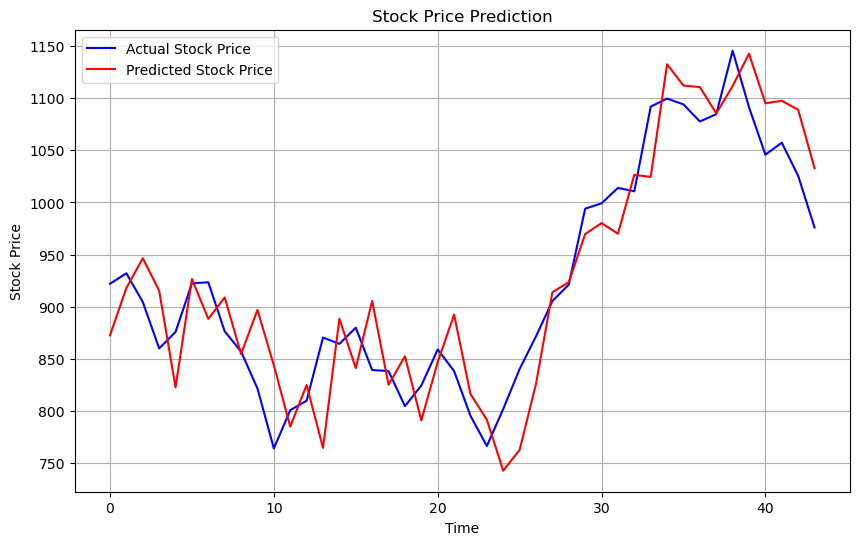

Root Mean Squared Error: 44.57758290014638
Mean Absolute Percentage Error: 0.04174571812481904
Thời gian training mô hình 32.381097078323364


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình',training_time)